# 은행 이탈 데이터 셋을 이용한 이진 분류
Binary Classification with a Bank Churn Dataset

## 참고사항: 
- 승환님: [id / surname] 컬럼 drop 후 중복행 삭제 후 모델링 진행
- 저의 경우, 컬럼 drop하지 않고 전체 컬럼으로 중복행 삭제 없이 모델링 진행

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 
import missingno as mno
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
import time

# 2. 데이터 탐색 및 전처리
- train 데이터 컬럼
    - id: ID
    - CustomerId: 고객ID
    - Surname: 성(이름)
    - CreditScore: 신용점수
    - Geography: 지역(국가)
    - Gender: 성별
    - Age: 나이
    - Tenure: 가입기간
    - Balance: 잔액
    - NumOfProducts: 고객 보유 상품 수
    - HasCrCard: 신용카드 유무 (1: Yes, 0: No)
    - IsActiveMember: 활성 멤버쉽 (1: Yes, 0: No)
    - EstimatedSalary: 예상 급여
    - Exited: 이탈 유무(1: Yes, 0: No) => 타겟 컬럼

In [3]:
# 데이터 불러오기(train, test, submission)
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')
original = pd.read_csv('./data/Churn_Modelling.csv')

In [4]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [6]:
train.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [7]:
test.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [8]:
# train 데이터 null값 확인
train.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<Axes: >

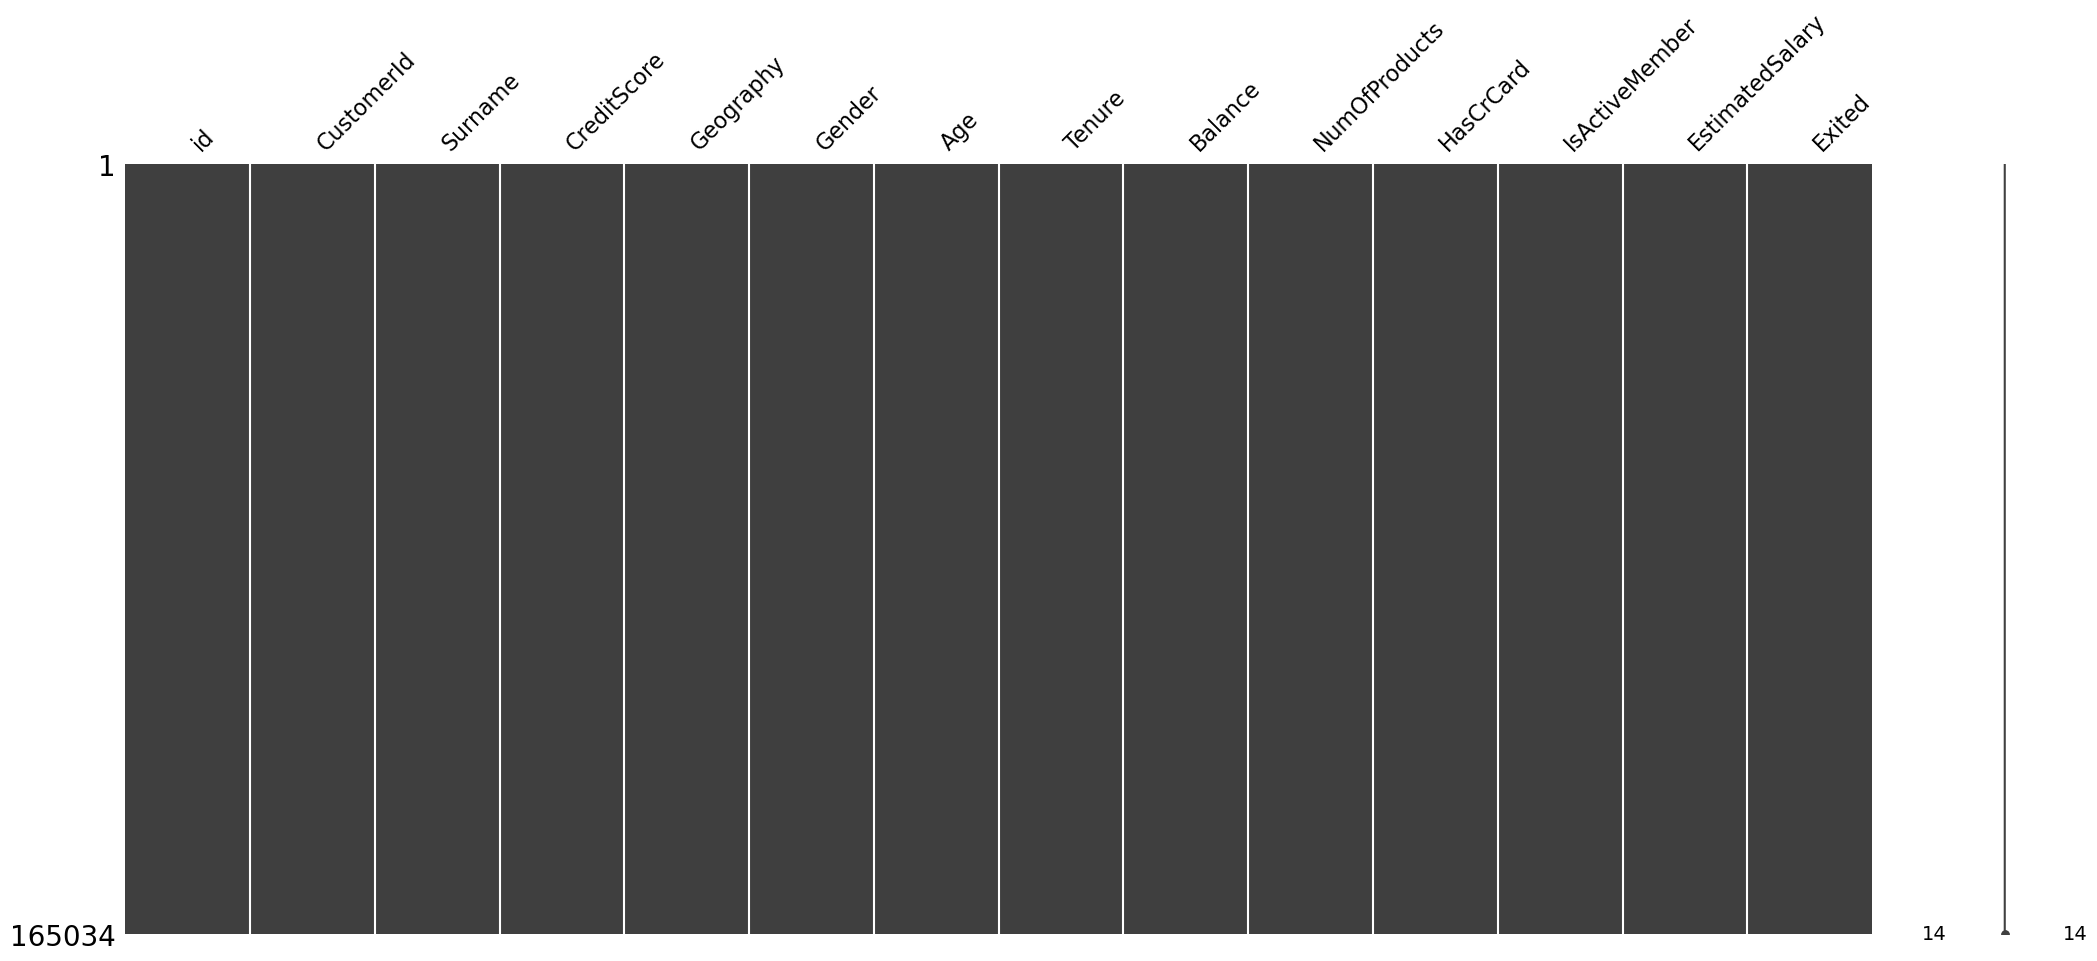

In [9]:
mno.matrix(train)


In [10]:
# test 데이터 null값 확인
test.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

<Axes: >

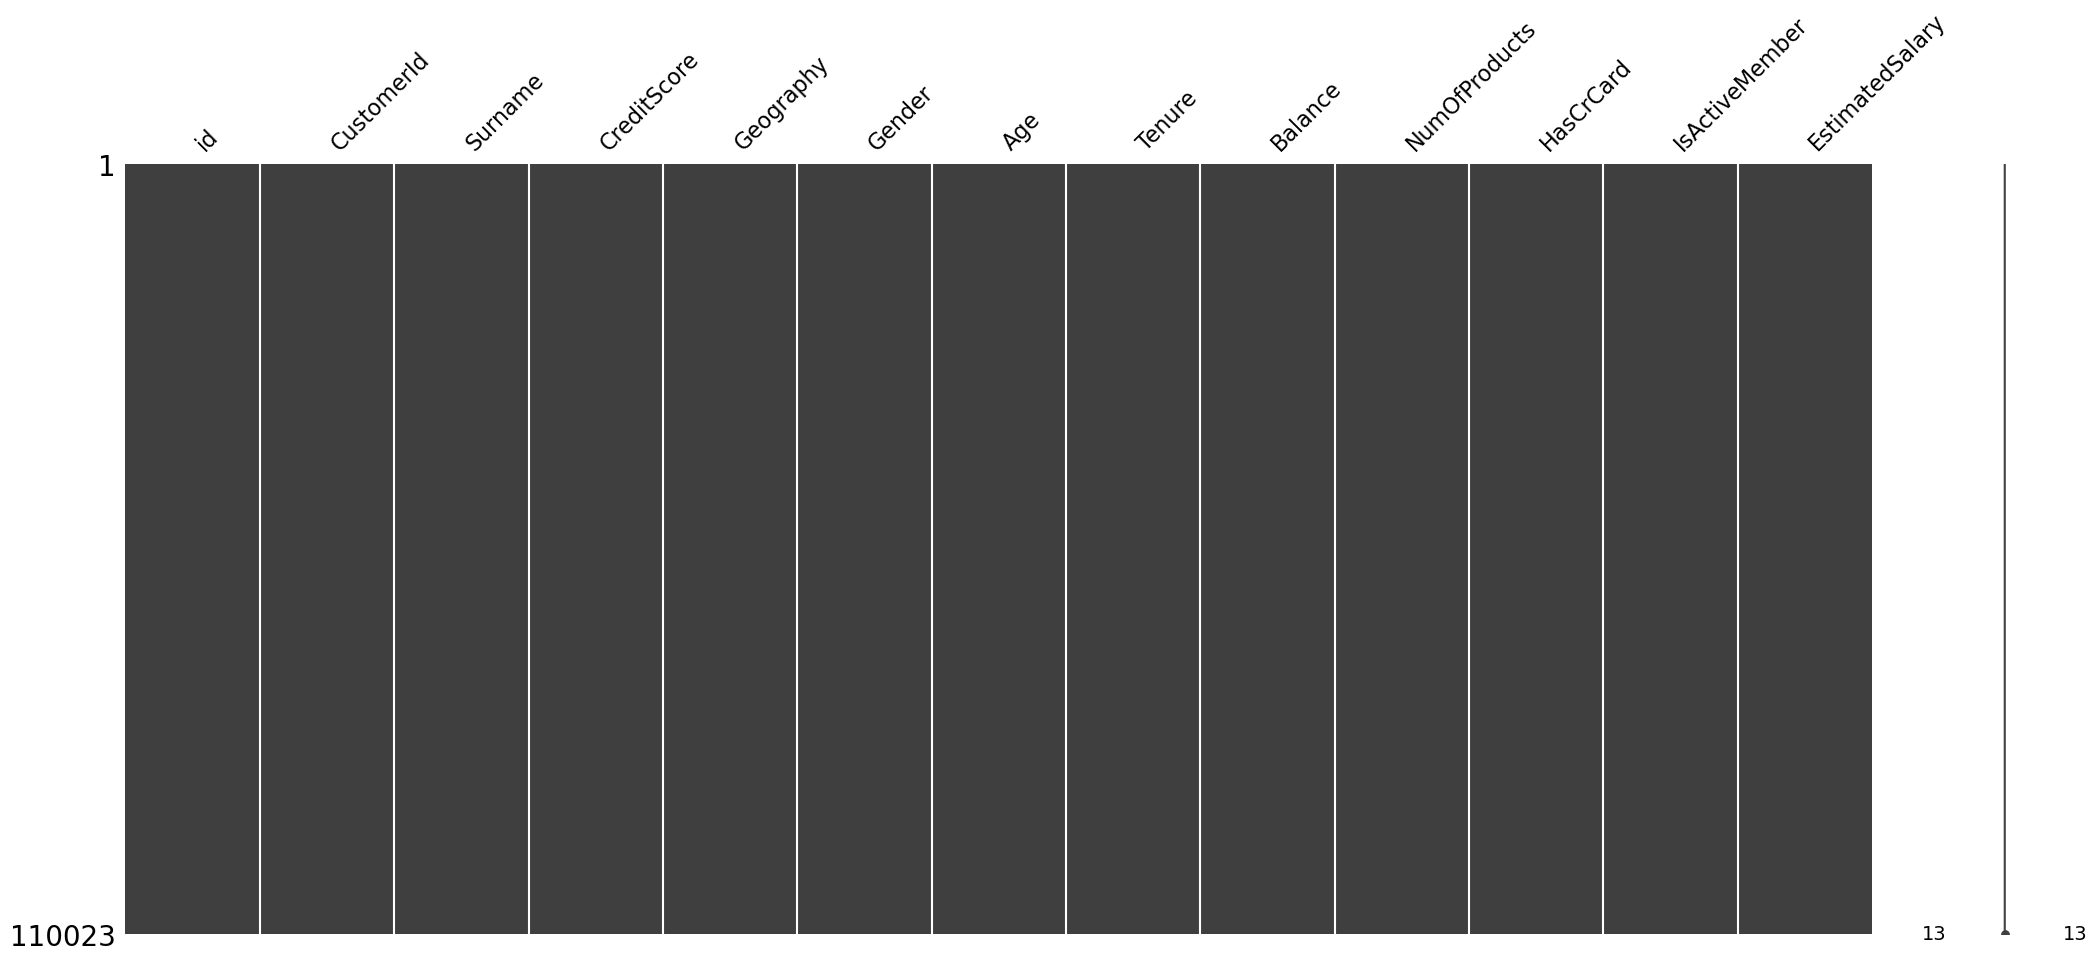

In [11]:
mno.matrix(test)


In [12]:
# train / test 데이터 크기 조회
train.shape

(165034, 14)

In [13]:
test.shape

(110023, 13)

In [14]:
# train / test 데이터 크기 및 비율 조회
print(f'Train data : {train.shape}')
print(f'Test data : {test.shape}')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data Percentage : {train_data_percentage * 100}%')
print(f'Test data Percentage : {(1- train_data_percentage) * 100}%')

Train data : (165034, 14)
Test data : (110023, 13)
Train data Percentage : 60.0%
Test data Percentage : 40.0%


In [15]:
# train 데이터 통계적 수치 확인
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,165034.0,8.251650e+04,47641.356500,0.00,41258.25,82516.5,1.237748e+05,165033.00
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,15633141.00,15690169.0,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,597.00,659.0,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,32.00,37.0,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.00,5.0,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.00,0.0,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.00,2.0,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.00,1.0,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.00,0.0,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,74637.57,117948.0,1.551525e+05,199992.48


In [16]:
# Train 데이터 형식 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [17]:
# 문자열 데이터인 Geography와 Gender 상세 개수 확인
train.Geography.value_counts()

Geography
France     94215
Spain      36213
Germany    34606
Name: count, dtype: int64

In [18]:
train.Gender.value_counts()

Gender
Male      93150
Female    71884
Name: count, dtype: int64

---

# Encoding

In [19]:
# one-hot encoding
train_ohe = pd.get_dummies(train[['Geography', 'Gender']])
train_ohe

,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,True,False,False,False,True
1,True,False,False,False,True
2,True,False,False,False,True
3,True,False,False,False,True
4,False,False,True,False,True
...,...,...,...,...,...
165029,False,False,True,True,False
165030,True,False,False,False,True
165031,True,False,False,False,True
165032,False,False,True,True,False


In [20]:
pre_ohe = train.drop(['Geography', 'Gender'], axis=1)
data = pd.concat([pre_ohe, train_ohe], axis=1)
columns_order = [col for col in data.columns if col != 'Exited']
data = data[columns_order + ['Exited']]
data.head()

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,181449.97,True,False,False,False,True,0
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,49503.50,True,False,False,False,True,0
2,2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,184866.69,True,False,False,False,True,0
3,3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,84560.88,True,False,False,False,True,0
4,4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,15068.83,False,False,True,False,True,0


---

# 5. Modeling
- Logistic Regression
- Decision Tree
- Random Forest
- LightBGM
- XGBoost
- CatBoost (추후 추가 예정)

In [21]:
# X, y 데이터 설정
X = data.drop(['Exited', 'id', 'CustomerId', 'Surname'], axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train.shape, y_train.shape

((132027, 13), (132027,))

In [22]:
# 나눈 데이터의 불균형 정도 확인

print(np.unique(y_train, return_counts=True)[1][1] / len(y_train) * 100, '%')

21.180516106553963 %


In [23]:
# oversampling
smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [24]:
X_train_over.shape, y_train_over.shape

((208126, 13), (208126,))

---

# 함수 정의

In [25]:
# 성능 지표 함수
def print_clf_eval(y_test, pred, pred_proba):

    start_time = time.time()

    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)

    confusion = confusion_matrix(y_test, pred)

    print('==> Confusion matrix')
    print(confusion)
    print('====================')

    print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc, pre)) 
    print('Recall : {0:.4f}, F1 : {1:.4f}, AUC : {2:.4f}'.format(re, f1, auc))
    print('Fit time : ', time.time() - start_time)
    print()

    return acc, pre, re, f1, auc

In [26]:
# 모델과 데이터를 주면 성능을 출력하는 함수
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]

    return print_clf_eval(y_test, pred, pred_proba)

In [27]:
# 다수의 모델의 성능을 정리해서 DataFrame으로 반환하는 함수
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['Accuracy', 'Precision',  'Recall',  'F1',  'Roc_Auc']
    tmp = []

    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [28]:
# 모델별 roc 커브 그리기
def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 10))

    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1] 
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label=model_names[model])

    plt.plot([0, 1],[0, 1], 'k--', label='random guess') 
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

---

# Logistic Regression


In [29]:
# class_weight
lr = LogisticRegression(random_state=13, class_weight='balanced')
lr.fit(X_train, y_train)
lr_proba = lr.predict_proba(X_test)
lr_pred = lr.predict(X_test)

print_clf_eval(y_test, lr_pred, lr_proba[:, 1])

==> Confusion matrix
[[17859  8191]
 [ 2245  4712]]
Accuracy : 0.6838, Precision : 0.3652
Recall : 0.6773, F1 : 0.4745, AUC : 0.7348
Fit time :  0.13164663314819336



(0.6838246432574908,
 0.36518639076183834,
 0.677303435388817,
 0.4745216515609265,
 0.7347728064664844)

# Decision Tree

In [30]:
# class_weight
lr = DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=13)
lr.fit(X_train, y_train)
lr_proba = lr.predict_proba(X_test)
lr_pred = lr.predict(X_test)

print_clf_eval(y_test, lr_pred, lr_proba[:, 1])

==> Confusion matrix
[[20198  5852]
 [ 1635  5322]]
Accuracy : 0.7732, Precision : 0.4763
Recall : 0.7650, F1 : 0.5871, AUC : 0.8441
Fit time :  0.0608363151550293



(0.7731693277183628,
 0.4762842312511187,
 0.764984907287624,
 0.5870608350339198,
 0.8441125427185423)

# Random Forest

In [31]:
# class_weight
rf = RandomForestClassifier(random_state=13, max_depth=3, class_weight='balanced')
rf.fit(X_train, y_train)
rf_proba = rf.predict_proba(X_test)
rf_pred = rf.predict(X_test)

print_clf_eval(y_test, rf_pred, rf_proba[:, 1])

==> Confusion matrix
[[20486  5564]
 [ 1692  5265]]
Accuracy : 0.7802, Precision : 0.4862
Recall : 0.7568, F1 : 0.5920, AUC : 0.8549
Fit time :  0.06682109832763672



(0.7801678431847789,
 0.48619447779111646,
 0.7567917205692108,
 0.5920386821095243,
 0.8548884275962265)

# LightGBM

In [32]:
# class_weight
lgbm = LGBMClassifier(random_state=13, max_depth=3, class_weight='balanced')
lgbm.fit(X_train, y_train)
lgbm_proba = lgbm.predict_proba(X_test)
lgbm_pred = lgbm.predict(X_test)

print_clf_eval(y_test, lgbm_pred, lgbm_proba[:, 1])

[LightGBM] [Info] Number of positive: 27964, number of negative: 104063
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
==> Confusion matrix
[[21139  4911]
 [ 1441  5516]]
Accuracy : 0.8076, Precision : 0.5290
Recall : 0.7929, F1 : 0.6346, AUC : 0.8875
Fit time :  0.0887608528137207



(0.8075559729754295,
 0.5290112208688981,
 0.792870490153802,
 0.6346065347445927,
 0.887536705459945)

# XGBoost(오버샘플링)

In [33]:
# over sampling
scale_pos_weight = y_train_over.value_counts()[0] / y_train_over.value_counts()[1]
xgb = XGBClassifier(random_state=13, max_depth=3, scale_pos_weight=scale_pos_weight)
xgb.fit(X_train_over, y_train_over)
xgb_proba = xgb.predict_proba(X_test)
xgb_pred = xgb.predict(X_test)

print_clf_eval(y_test, xgb_pred, xgb_proba[:, 1])

==> Confusion matrix
[[24433  1617]
 [ 2887  4070]]
Accuracy : 0.8635, Precision : 0.7157
Recall : 0.5850, F1 : 0.6438, AUC : 0.8872
Fit time :  0.12965822219848633



(0.8635440967067591,
 0.7156673114119922,
 0.5850222797182694,
 0.6437836127807656,
 0.887223426494035)

# CatBoost

- 과적합 문제를 해결하면서 학습 속도를 개선하는 장점을 앞세워 개발되었습니다.
- 또한 하이퍼 파라미터에 따라 성능이 달라지는 민감한 문제를 해결하는 것에도 초점을 맞추었습니다.
- (기본 파라미터가 기본적으로 최적화가 잘 되어있어서 파라미터 튜닝에 크게 신경쓰지 않아도 됨)
- 비시계열 데이터라도 CatBoost가 임의로 시계열을 형성해 Boosting을 진행합니다.
- 따라서 Ordered Boosting이라고도 불립니다.
- 결측치가 많은 데이터셋에는 부적합한 모델입니다.

In [34]:
# scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
cat = CatBoostClassifier(random_state=13, max_depth=3, scale_pos_weight=scale_pos_weight)
cat.fit(X_train, y_train)
cat_proba = cat.predict_proba(X_test)
cat_pred = cat.predict(X_test)

print_clf_eval(y_test, cat_pred, cat_proba[:, 1])

Learning rate set to 0.082881
0:	learn: 0.6568412	total: 203ms	remaining: 3m 22s
1:	learn: 0.6273630	total: 232ms	remaining: 1m 55s
2:	learn: 0.6035296	total: 278ms	remaining: 1m 32s
3:	learn: 0.5839598	total: 318ms	remaining: 1m 19s
4:	learn: 0.5670545	total: 353ms	remaining: 1m 10s
5:	learn: 0.5533928	total: 380ms	remaining: 1m 2s
6:	learn: 0.5407231	total: 401ms	remaining: 56.8s
7:	learn: 0.5310295	total: 425ms	remaining: 52.7s
8:	learn: 0.5221199	total: 446ms	remaining: 49.1s
9:	learn: 0.5151301	total: 465ms	remaining: 46.1s
10:	learn: 0.5090887	total: 489ms	remaining: 44s
11:	learn: 0.5014916	total: 528ms	remaining: 43.5s
12:	learn: 0.4963370	total: 577ms	remaining: 43.8s
13:	learn: 0.4903961	total: 613ms	remaining: 43.1s
14:	learn: 0.4858290	total: 645ms	remaining: 42.4s
15:	learn: 0.4823293	total: 672ms	remaining: 41.3s
16:	learn: 0.4789853	total: 697ms	remaining: 40.3s
17:	learn: 0.4746249	total: 725ms	remaining: 39.5s
18:	learn: 0.4710356	total: 754ms	remaining: 38.9s
19:	lear

(0.8106765231617535,
 0.5343756069139639,
 0.7910018686215323,
 0.6378441031585048,
 0.8893545985939955)

---

# 성능 평가표

In [35]:
# 6개의 분류 모델을 한번에 표로 정리(oversampling X)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
lr_clf = LogisticRegression(random_state=13, solver='liblinear', class_weight='balanced')
dt_clf = DecisionTreeClassifier(random_state=13, max_depth=3, class_weight='balanced')
rf_clf = RandomForestClassifier(random_state=13, max_depth=3, class_weight='balanced')
lgbm_clf = LGBMClassifier(random_state=13, max_depth=3, class_weight='balanced', boost_from_average=False) 
xgb_clf = XGBClassifier(random_state=13, max_depth=3, scale_pos_weight=scale_pos_weight)
cat_clf = CatBoostClassifier(random_state=13, max_depth=3, scale_pos_weight=scale_pos_weight)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, xgb_clf, cat_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGB', 'CatBoost']
 
result = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
result
     

==> Confusion matrix
[[19650  6400]
 [ 1854  5103]]
Accuracy : 0.7499, Precision : 0.4436
Recall : 0.7335, F1 : 0.5529, AUC : 0.8143
Fit time :  0.07779192924499512

==> Confusion matrix
[[20198  5852]
 [ 1635  5322]]
Accuracy : 0.7732, Precision : 0.4763
Recall : 0.7650, F1 : 0.5871, AUC : 0.8441
Fit time :  0.06084179878234863

==> Confusion matrix
[[20486  5564]
 [ 1692  5265]]
Accuracy : 0.7802, Precision : 0.4862
Recall : 0.7568, F1 : 0.5920, AUC : 0.8549
Fit time :  0.07277441024780273

[LightGBM] [Info] Number of positive: 27964, number of negative: 104063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
==> Confusion matrix
[[21139  4911]
 [ 1441  5516]]
Accuracy : 0.8

,Accuracy,Precision,Recall,F1,Roc_Auc
LogisticRegression,0.749932,0.443623,0.733506,0.552871,0.814256
DecisionTree,0.773169,0.476284,0.764985,0.587061,0.844113
RandomForest,0.780168,0.486194,0.756792,0.592039,0.854888
LightGBM,0.807556,0.529011,0.792870,0.634607,0.887537
XGB,0.810252,0.533533,0.793589,0.638081,0.889002
CatBoost,0.810677,0.534376,0.791002,0.637844,0.889355


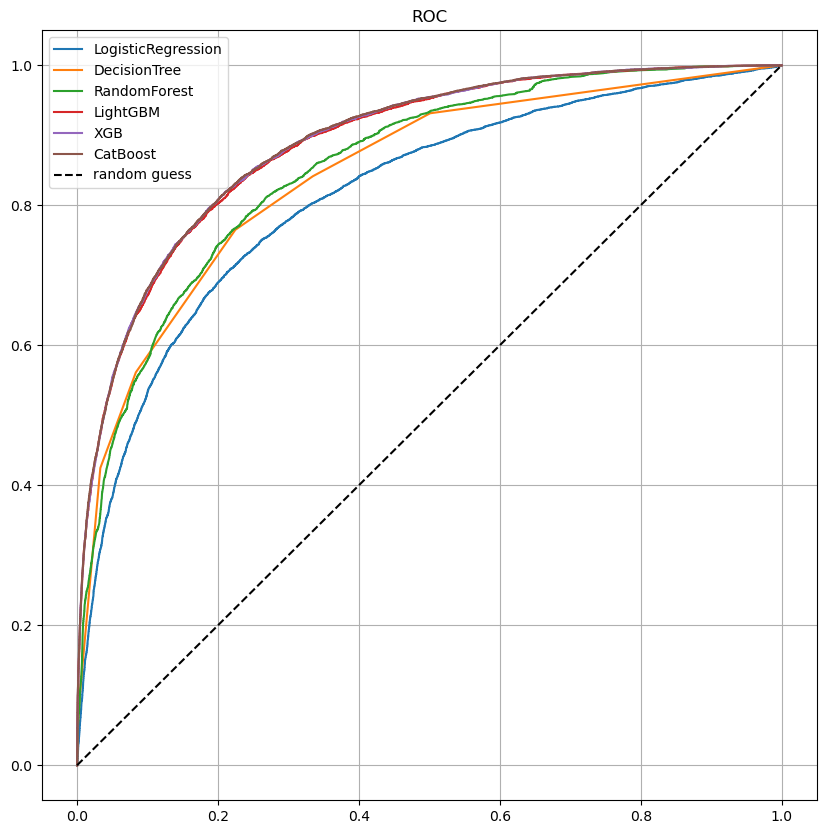

In [36]:
# class weight
draw_roc_curve(models, model_names, X_test, y_test)

# 모델링 결과:
- accuracy score 결과로는 cat > xgb > lgbm => 0.80 또는 0.81대
- recall 결과로는 xgb > lgbm > cat => 0.79대 
- roc_auc score 결과로는 cat > xgb > lgbm => 0.88대

---

# 최적의 파라미터값 구하기(GridSearchCV)

하이퍼 파라미터 튜닝 진행
- 모델링 결과가 좋았던 3개 모델 활용
    - lgbm
    - xgb
    - cat


#### LightGBM

In [37]:
params = {
    'n_estimator' : [50, 100, 300],
    'num_leaves': [10, 20, 30],
    'max_depth': [3, 7, 10, 20],
    'learning_rate': [0.05, 0.1, 0.3]
}

grid = GridSearchCV(lgbm_clf, param_grid=params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
lgbm_best = grid.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Info] Number of positive: 27964, number of negative: 104063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13


In [38]:
# best score 체크
print(f'grid.best_score: {grid.best_score_}')

# best params 체크
print(f'grid.best_params: {grid.best_params_}')

# test 데이터에서의 성능
print(f'accuracy score of test data: {accuracy_score(y_test, grid.best_estimator_.predict(X_test))}')

grid.best_score: 0.8890259694644858
grid.best_params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimator': 50, 'num_leaves': 20}
[LightGBM] [Warning] Unknown parameter: n_estimator


accuracy score of test data: 0.8141606325930864


#### XGB

In [39]:
params = {
    'max_depth' : [3, 7, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid = GridSearchCV(xgb_clf, param_grid=params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
xgb_best = grid.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [40]:
# best score 체크
print(f'grid.best_score: {grid.best_score_}')

# best params 체크
print(f'grid.best_params: {grid.best_params_}')

# test 데이터에서의 성능
print(f'accuracy score of test data: {accuracy_score(y_test, grid.best_estimator_.predict(X_test))}')

grid.best_score: 0.8882276853700989
grid.best_params: {'learning_rate': 0.1, 'max_depth': 3}
accuracy score of test data: 0.80673796467416


#### CatBoost

In [41]:
params = {
    'max_depth': [3, 7, 10]
}

grid = GridSearchCV(cat_clf, param_grid=params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
cat_best = grid.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


Learning rate set to 0.082881
0:	learn: 0.6568412	total: 22.2ms	remaining: 22.1s
1:	learn: 0.6273630	total: 44.7ms	remaining: 22.3s
2:	learn: 0.6035296	total: 65.5ms	remaining: 21.8s
3:	learn: 0.5839598	total: 86.3ms	remaining: 21.5s
4:	learn: 0.5670545	total: 106ms	remaining: 21.1s
5:	learn: 0.5533928	total: 128ms	remaining: 21.3s
6:	learn: 0.5407231	total: 149ms	remaining: 21.1s
7:	learn: 0.5310295	total: 170ms	remaining: 21s
8:	learn: 0.5221199	total: 194ms	remaining: 21.4s
9:	learn: 0.5151301	total: 221ms	remaining: 21.9s
10:	learn: 0.5090887	total: 254ms	remaining: 22.8s
11:	learn: 0.5014916	total: 284ms	remaining: 23.4s
12:	learn: 0.4963370	total: 312ms	remaining: 23.7s
13:	learn: 0.4903961	total: 342ms	remaining: 24.1s
14:	learn: 0.4858290	total: 364ms	remaining: 23.9s
15:	learn: 0.4823293	total: 383ms	remaining: 23.5s
16:	learn: 0.4789853	total: 406ms	remaining: 23.5s
17:	learn: 0.4746249	total: 432ms	remaining: 23.6s
18:	learn: 0.4710356	total: 468ms	remaining: 24.2s
19:	learn

In [42]:
# best score 체크
print(f'grid.best_score: {grid.best_score_}')

# best params 체크
print(f'grid.best_params: {grid.best_params_}')

# test 데이터에서의 성능
print(f'accuracy score of test data: {accuracy_score(y_test, grid.best_estimator_.predict(X_test))}')

grid.best_score: 0.8891916151896445
grid.best_params: {'max_depth': 3}
accuracy score of test data: 0.8106765231617535


#### 비교

In [43]:
# 그리드서치 후 모델 성능 비교
models = [lgbm_best, xgb_best, cat_best]
model_names = ['LightGBM', 'XGB', 'CatBoost']

results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
results

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Info] Number of positive: 27964, number of negative: 104063
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: n_estimator
==> Confusion matrix
[[21392  4658]
 [ 1476  5481]]
Accuracy : 0.8142, Precision : 0.5406
Recall : 0.7878, F1 : 0.6412, AUC : 0.8886
Fit time :  0.08278012275695801

==> Confusion matrix
[[21108  4942]
 [ 1437  5520]]
Accuracy : 0.8067, Precision : 0.5276
Recall : 0.7934, F1 : 0.6338, AUC : 0.8878
Fit time :  0.12566399574279785

Learning rate set to 0.082881
0:	le

,Accuracy,Precision,Recall,F1,Roc_Auc
LightGBM,0.814161,0.540586,0.787840,0.641203,0.888581
XGB,0.806738,0.527624,0.793445,0.633791,0.887751
CatBoost,0.810677,0.534376,0.791002,0.637844,0.889355


[LightGBM] [Warning] Unknown parameter: n_estimator


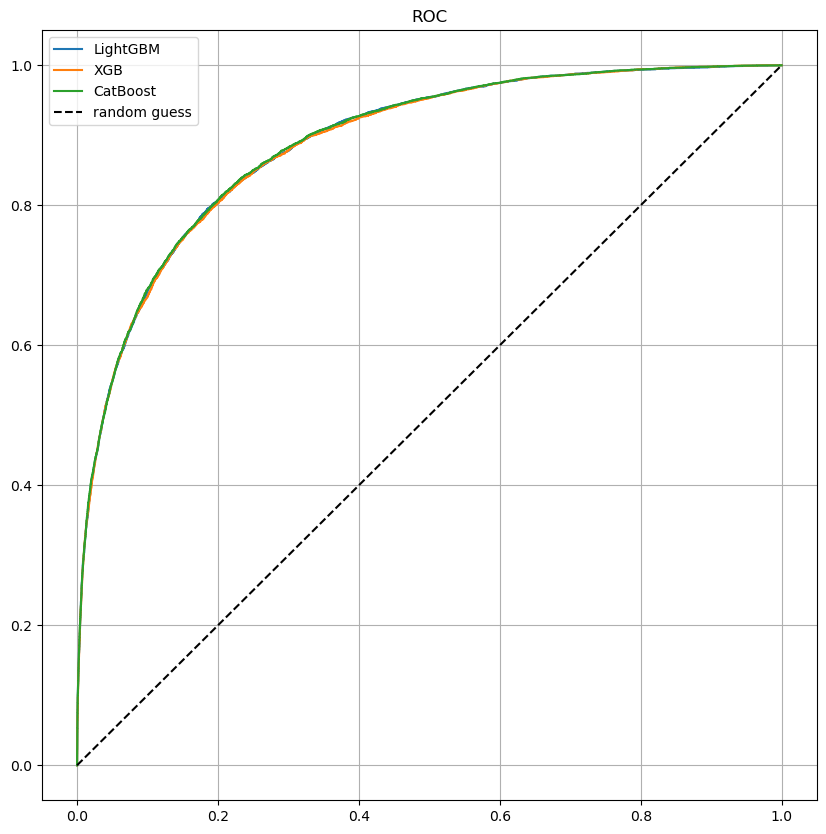

In [44]:
# roc 곡선 그리기
draw_roc_curve(models, model_names, X_test, y_test)

## 결과:
- 하이퍼 파라미터 튜닝 후, 모델 성능 소폭 향상(accuracy, recall, auc 면에서)


---

# 중요 특성 파악하기

#### lgbm

In [45]:
# 중요 특성 확인(영향력이 높은 feature들만 추려서 정렬)
best_cols_values = lgbm_best.feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train.columns)
top_cols = best_cols.sort_values(ascending=False)
top_cols

Age                  364
Balance              344
CreditScore          269
EstimatedSalary      228
NumOfProducts        213
IsActiveMember       129
Geography_Germany    103
Gender_Female         93
Tenure                81
HasCrCard             47
Geography_France      16
Geography_Spain       13
Gender_Male            0
dtype: int32

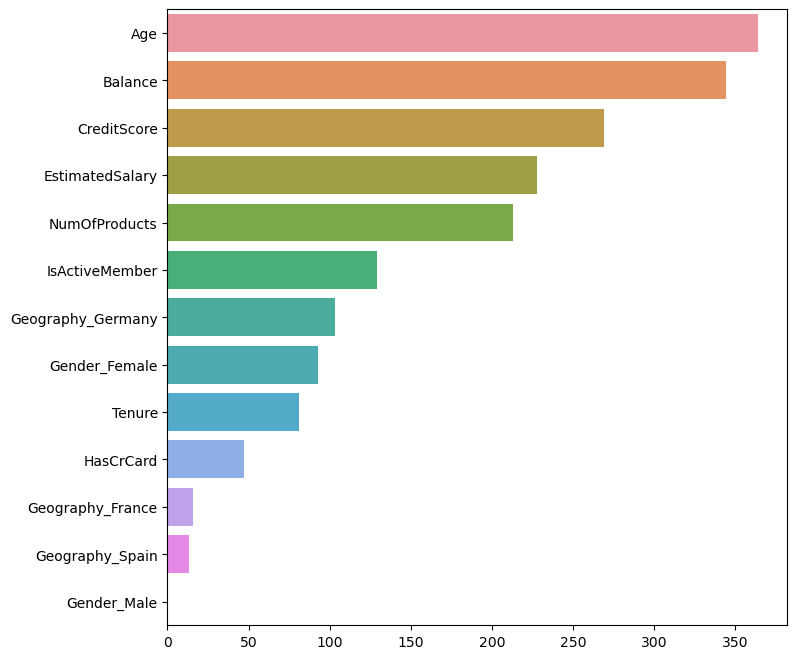

In [47]:
# 주요 특성 관찰
plt.figure(figsize=(8,8))
sns.barplot(x=top_cols, y=top_cols.index)
plt.show()

#### xgb

In [48]:
# 중요 특성 확인(영향력이 높은 feature들만 추려서 정렬)
best_cols_values = xgb_best.feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train.columns)
top_cols = best_cols.sort_values(ascending=False)
top_cols


Age                  0.262411
NumOfProducts        0.252387
Geography_Germany    0.160851
IsActiveMember       0.144510
Gender_Female        0.084950
Balance              0.058749
HasCrCard            0.015223
CreditScore          0.006337
Tenure               0.005119
EstimatedSalary      0.004883
Geography_France     0.004580
Geography_Spain      0.000000
Gender_Male          0.000000
dtype: float32

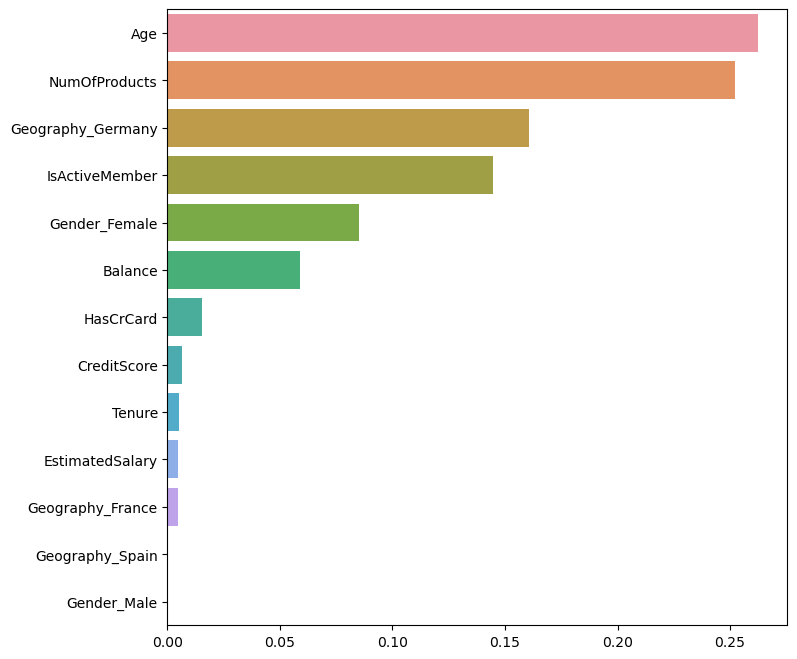

In [49]:
# 주요 특성 관찰
plt.figure(figsize=(8,8))
sns.barplot(x=top_cols, y=top_cols.index)
plt.show()

#### cat

In [50]:
# 중요 특성 확인(영향력이 높은 feature들만 추려서 정렬)
best_cols_values = cat_best.feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train.columns)
top_cols = best_cols.sort_values(ascending=False)
top_cols


NumOfProducts        44.685325
Age                  26.263895
IsActiveMember        8.512619
Balance               7.013457
Geography_Germany     5.478337
CreditScore           2.180272
EstimatedSalary       1.791717
Gender_Male           1.638568
Gender_Female         1.165735
Tenure                0.695038
HasCrCard             0.418390
Geography_Spain       0.116380
Geography_France      0.040268
dtype: float64

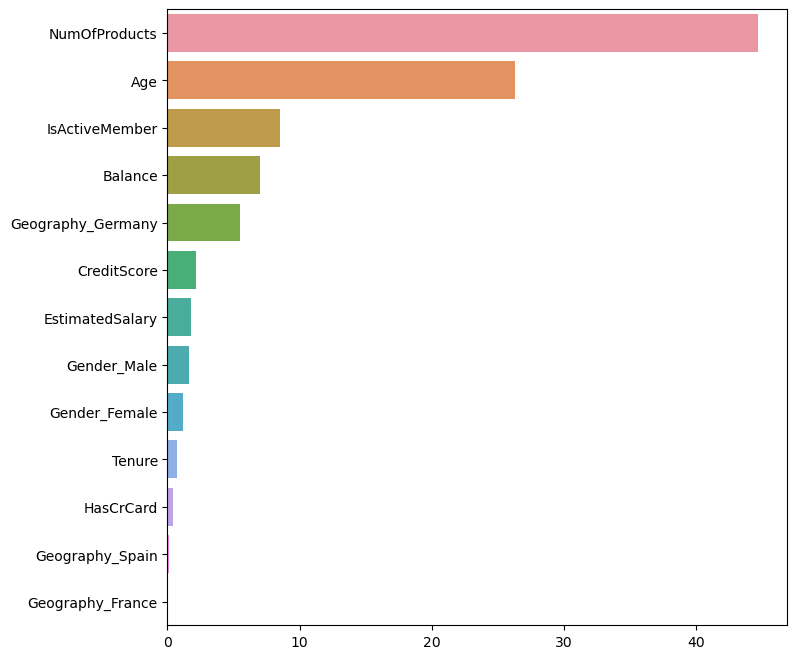

In [51]:
# 주요 특성 관찰
plt.figure(figsize=(8,8))
sns.barplot(x=top_cols, y=top_cols.index)
plt.show()

# 결과:

- lgbm : 나이 > 잔액 > 신용점수 > 예상급여
- xgb : 나이 > 상품 수 > 국가(독일) > 활성멤버 여부
- cat : 상품 수 > 나이 > 활성멤버 여부 > 잔액

- 대체로 나이, 상품 수, 잔액, 활성멤버 여부 4가지 특성의 중요도가 높은 것 확인

---

# 이상치 탐지

In [52]:
# outlier 탐지 함수 활용
def outlier_detector(df, cols, take_care_outliners=False, print_outliners=False, q_1=0.25, q_3=0.75):
    '''
    Detect outliers in the dataframe by trimming method
    Args:
        df: dataframe
        cols: list of columns to detect outliers
        take_care_outliners: if True, remove outliers from the dataframe
        print_outliners: if True, print outliners
        q_1: lower quartile
        q_3: upper quartile
    Return:
        temp: dataframe contains outliers information
        data: dataframe after removing outliers
    '''
    temp = pd.DataFrame()
    data_copy = df.copy()
    for col in cols:
        Q1 = data_copy[col].quantile(q_1)
        Q3 = data_copy[col].quantile(q_3)
        IQR = Q3 - Q1
        upper = Q3 + 1.5 * IQR
        lower = Q1 - 1.5 * IQR
        
        temp.loc[col, "Min"] = round(data_copy[col].min())
        temp.loc[col, "Low_Limit"] = round(lower)
        temp.loc[col, "Mean"] = round(data_copy[col].mean())
        temp.loc[col, "Median"] = round(data_copy[col].median())
        temp.loc[col,"Up_Limit"] = round(upper)
        temp.loc[col, "Max"] = data_copy[col].max()        
        temp.loc[col, "Outlier"] = "Min-Max" if (data_copy[col].max() > upper) & (lower > data_copy[col].min())\
                                    else ("Max" if data_copy[col].max() > upper \
                                    else ("Min" if lower > data_copy[col].min() \
                                    else "No"))
        temp.loc[col, 'Number of Outliers'] = data_copy.loc[(data[col] > upper) | (data_copy[col] < lower)].shape[0]
        
        if take_care_outliners:
            # data_copy = data_copy[(data_copy[col] <= upper) & (data_copy[col] >= lower)]
            data_copy.loc[data_copy[col] > upper, col] = round(upper - 1)
            data_copy.loc[data_copy[col] < lower, col] = round(lower + 1)
    return temp if print_outliners else data_copy if take_care_outliners else None

## train 데이터 이상치 탐지

In [60]:
feature_importance = ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance', 'CreditScore', 'EstimatedSalary'] 

In [63]:
outlier_detector(train, feature_importance, print_outliners=True)

,Min,Low_Limit,Mean,Median,Up_Limit,Max,Outlier,Number of Outliers
Age,18.0,17.0,38.0,37.0,57.0,92.00,Max,6394.0
NumOfProducts,1.0,0.0,2.0,2.0,4.0,4.00,Max,475.0
IsActiveMember,0.0,-2.0,0.0,0.0,2.0,1.00,No,0.0
Balance,0.0,-179909.0,55478.0,0.0,299849.0,250898.09,No,0.0
CreditScore,350.0,428.0,656.0,659.0,880.0,850.00,Min,253.0
EstimatedSalary,12.0,-46135.0,112575.0,117948.0,275925.0,199992.48,No,0.0


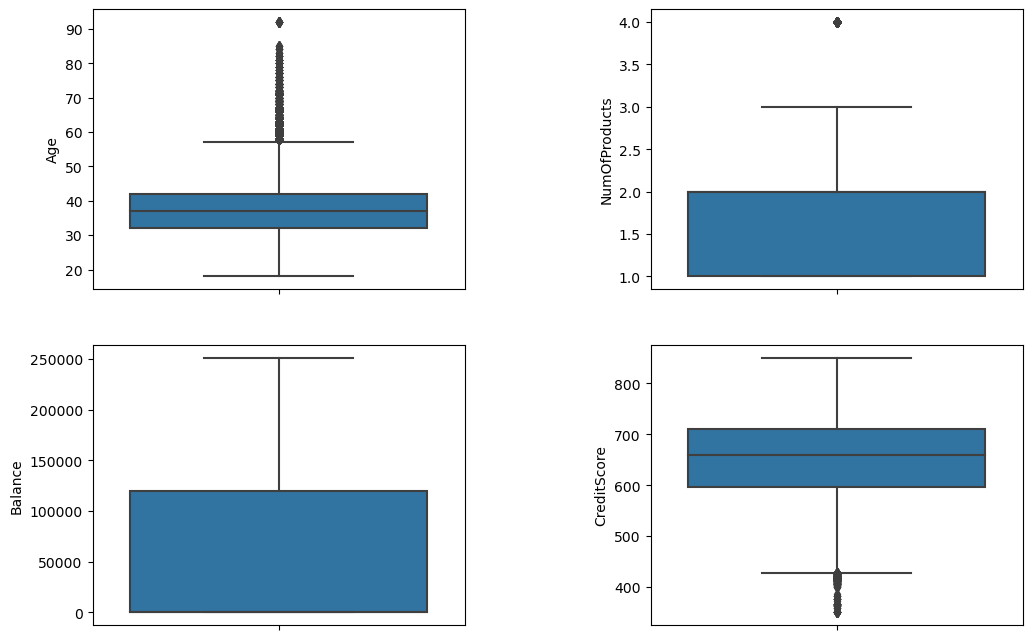

In [67]:
# age, numofproducts, balance, creditscore 이상치 그래프로 확인 
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sns.boxplot(y='Age', data=train, ax=ax[0, 0])
sns.boxplot(y='NumOfProducts', data=train, ax=ax[0, 1])
sns.boxplot(y='Balance', data=train, ax=ax[1, 0])
sns.boxplot(y='CreditScore', data=train, ax=ax[1, 1])
plt.subplots_adjust(wspace=0.5)
plt.show()

## test 데이터 이상치 탐지

In [62]:
outlier_detector(test, feature_importance, print_outliners=True)

,Min,Low_Limit,Mean,Median,Up_Limit,Max,Outlier,Number of Outliers
Age,18.0,17.0,38.0,37.0,57.0,92.00,Max,4234.0
NumOfProducts,1.0,0.0,2.0,2.0,4.0,4.00,Max,331.0
IsActiveMember,0.0,-2.0,0.0,0.0,2.0,1.00,No,0.0
Balance,0.0,-180218.0,55334.0,0.0,300364.0,250898.09,No,0.0
CreditScore,350.0,428.0,657.0,660.0,880.0,850.00,Min,176.0
EstimatedSalary,12.0,-45846.0,112315.0,117832.0,274918.0,199992.48,No,0.0


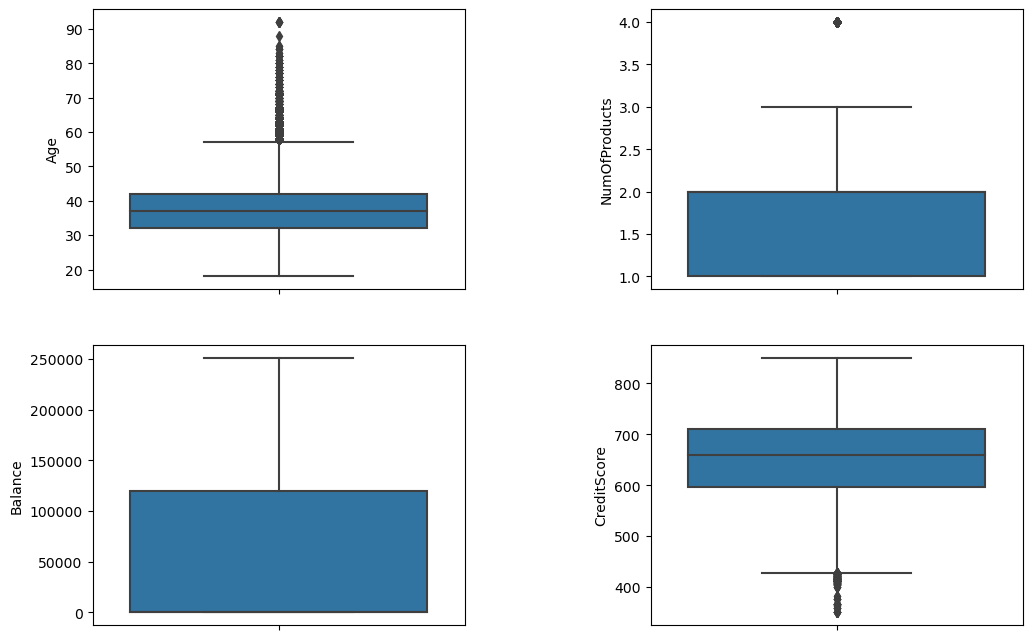

In [68]:
# age, numofproducts, balance, creditscore 이상치 그래프로 확인 
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sns.boxplot(y='Age', data=test, ax=ax[0, 0])
sns.boxplot(y='NumOfProducts', data=test, ax=ax[0, 1])
sns.boxplot(y='Balance', data=test, ax=ax[1, 0])
sns.boxplot(y='CreditScore', data=test, ax=ax[1, 1])
plt.subplots_adjust(wspace=0.5)
plt.show()

# original 데이터 이상치 탐지

In [69]:
outlier_detector(original, feature_importance, print_outliners=True)

,Min,Low_Limit,Mean,Median,Up_Limit,Max,Outlier,Number of Outliers
Age,18.0,14.0,39.0,37.0,62.0,92.00,Max,154.0
NumOfProducts,1.0,0.0,2.0,1.0,4.0,4.00,Max,31.0
IsActiveMember,0.0,-2.0,1.0,1.0,2.0,1.00,No,0.0
Balance,0.0,-191472.0,76491.0,97199.0,319120.0,250898.09,No,0.0
CreditScore,350.0,383.0,651.0,652.0,919.0,850.00,Min,15.0
EstimatedSalary,12.0,-96616.0,100083.0,100185.0,296984.0,199992.48,No,0.0


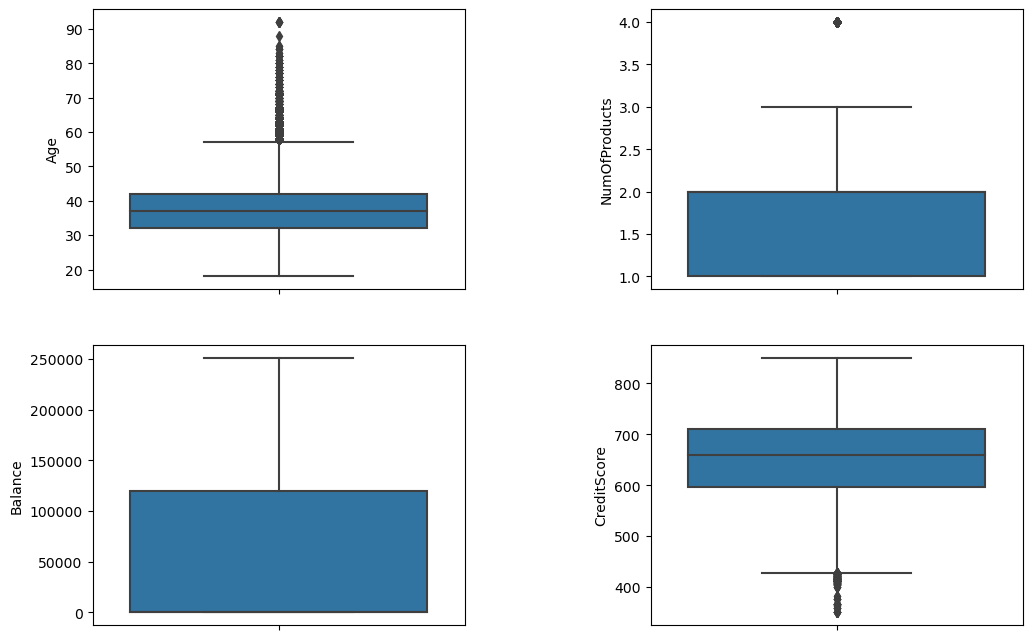

In [70]:
# age, numofproducts, balance, creditscore 이상치 그래프로 확인 
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sns.boxplot(y='Age', data=test, ax=ax[0, 0])
sns.boxplot(y='NumOfProducts', data=test, ax=ax[0, 1])
sns.boxplot(y='Balance', data=test, ax=ax[1, 0])
sns.boxplot(y='CreditScore', data=test, ax=ax[1, 1])
plt.subplots_adjust(wspace=0.5)
plt.show()

# 결과:
- train, test, original 데이터에 비슷한 이상치 데이터 존재

# 이상치 제거

In [71]:
# 이상치 제거 함수
def remove_outlier(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

In [74]:
df_remove1 = remove_outlier(train, 'Age')
df_remove2 = remove_outlier(df_remove1, 'CreditScore')
df_remove3 = remove_outlier(df_remove2, 'NumOfProducts')

In [75]:
df_remove3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156991 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               156991 non-null  int64  
 1   CustomerId       156991 non-null  int64  
 2   Surname          156991 non-null  object 
 3   CreditScore      156991 non-null  int64  
 4   Geography        156991 non-null  object 
 5   Gender           156991 non-null  object 
 6   Age              156991 non-null  float64
 7   Tenure           156991 non-null  int64  
 8   Balance          156991 non-null  float64
 9   NumOfProducts    156991 non-null  int64  
 10  HasCrCard        156991 non-null  float64
 11  IsActiveMember   156991 non-null  float64
 12  EstimatedSalary  156991 non-null  float64
 13  Exited           156991 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 18.0+ MB


In [76]:
len(train) - len(df_remove3)

8043

In [77]:
df_ohe = pd.get_dummies(df_remove3[['Geography', 'Gender']])
pre_ohe = df_remove3.drop(['Geography', 'Gender'], axis=1)
data = pd.concat([pre_ohe, df_ohe], axis=1)
columns_order = [col for col in data.columns if col != 'Exited']
data = data[columns_order + ['Exited']]
data.head()

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,181449.97,True,False,False,False,True,0
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,49503.50,True,False,False,False,True,0
2,2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,184866.69,True,False,False,False,True,0
3,3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,84560.88,True,False,False,False,True,0
4,4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,15068.83,False,False,True,False,True,0


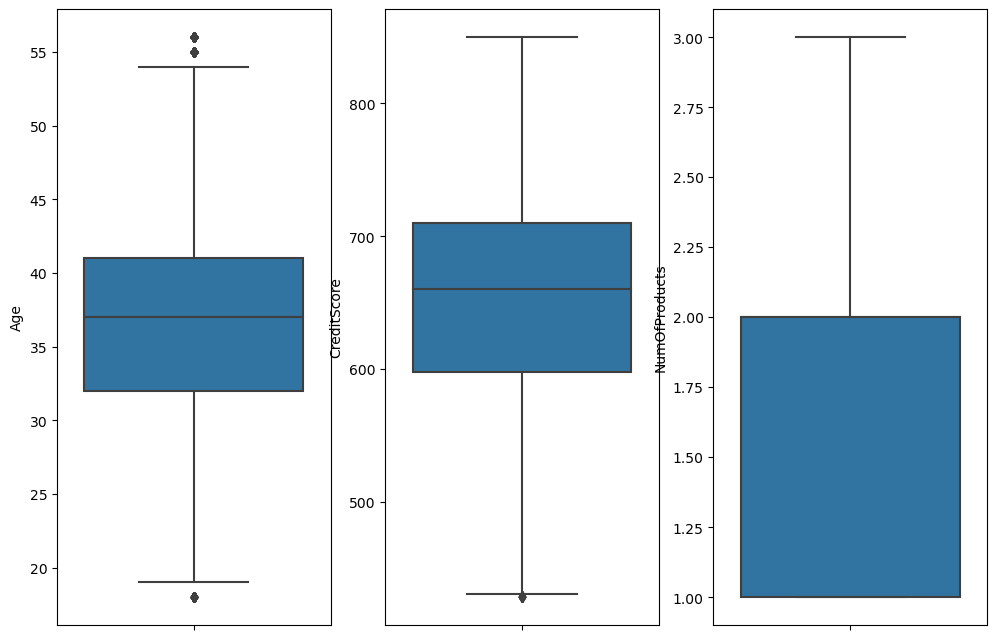

In [79]:
fig, ax = plt.subplots(1, 3,figsize=(12, 8))
sns.boxplot(y='Age', data=df_remove3, ax=ax[0])
sns.boxplot(y='CreditScore', data=df_remove3, ax=ax[1])
sns.boxplot(y='NumOfProducts', data=df_remove3, ax=ax[2])
plt.show()

In [80]:
# X, y 데이터 설정
X = data.drop(['Exited', 'id', 'CustomerId', 'Surname'], axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train.shape, y_train.shape

((125592, 13), (125592,))

In [81]:
models = [lgbm_best, xgb_best, cat_best]
model_names = ['LightGBM', 'XGB', 'CatBoost']

results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
results

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Info] Number of positive: 25232, number of negative: 100360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 125592, number of used features: 13
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: n_estimator
==> Confusion matrix
[[20539  4572]
 [ 1353  4935]]
Accuracy : 0.8113, Precision : 0.5191
Recall : 0.7848, F1 : 0.6249, AUC : 0.8845
Fit time :  0.10025310516357422

==> Confusion matrix
[[20580  4531]
 [ 1387  4901]]
Accuracy : 0.8115, Precision : 0.5196
Recall : 0.7794, F1 : 0.6235, AUC : 0.8838
Fit time :  0.11123156547546387

Learning rate set to 0.081132
0:	le

,Accuracy,Precision,Recall,F1,Roc_Auc
LightGBM,0.811300,0.519091,0.784828,0.624881,0.884513
XGB,0.811523,0.519614,0.779421,0.623537,0.883844
CatBoost,0.814612,0.525191,0.774173,0.625828,0.884634


# 결과 (이상치 제거 후 모델 성능 비교)
- lgbm: accuracy 하락, recall 하락, roc_auc 하락
- xgb: accuracy 상승, recall 하락, roc_auc 하락
- cat: accuracy 상승, recall 하락, roc_auc 하락

- 소폭으로 변동했지만 이상치 제거하지 않는 것이 성능이 더 좋은 것 확인

## 이상치 제거 후 중요도 확인(xgb, cat)


#### xgb

In [82]:
# 중요 특성 확인(영향력이 높은 feature들만 추려서 정렬)
best_cols_values = xgb_best.feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train.columns)
top_cols = best_cols.sort_values(ascending=False)
top_cols

Age                  0.320042
NumOfProducts        0.241771
Geography_Germany    0.130225
IsActiveMember       0.126255
Gender_Female        0.089806
Balance              0.058843
HasCrCard            0.014608
CreditScore          0.006143
Tenure               0.005809
EstimatedSalary      0.004665
Geography_Spain      0.001832
Geography_France     0.000000
Gender_Male          0.000000
dtype: float32

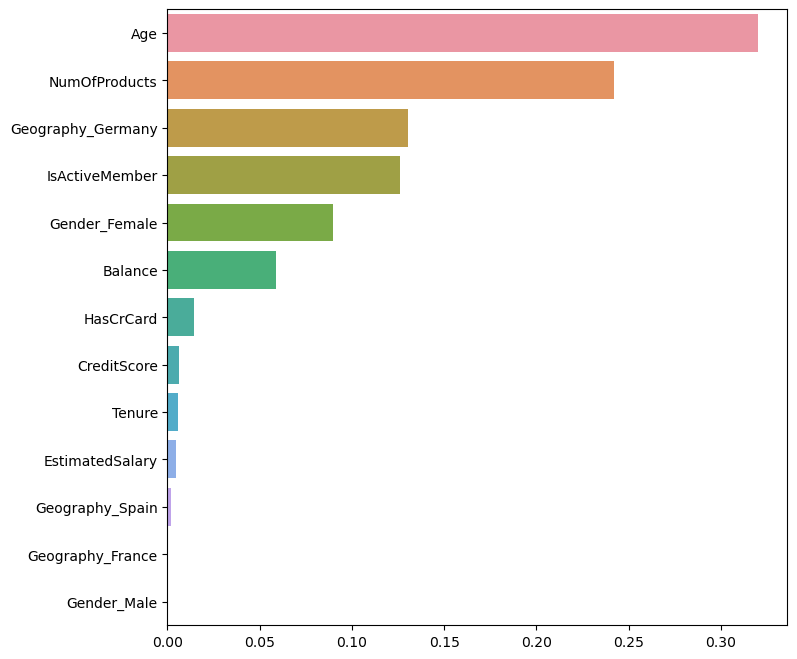

In [83]:
# 주요 특성 관찰
plt.figure(figsize=(8,8))
sns.barplot(x=top_cols, y=top_cols.index)
plt.show()

#### cat

In [84]:
# 중요 특성 확인(영향력이 높은 feature들만 추려서 정렬)
best_cols_values = cat_best.feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train.columns)
top_cols = best_cols.sort_values(ascending=False)
top_cols


NumOfProducts        44.941238
Age                  25.319281
Balance               7.713092
IsActiveMember        7.534224
Geography_Germany     5.556539
CreditScore           2.606044
EstimatedSalary       2.060478
Gender_Male           1.754022
Gender_Female         1.129614
Tenure                0.762041
HasCrCard             0.462163
Geography_Spain       0.091906
Geography_France      0.069360
dtype: float64

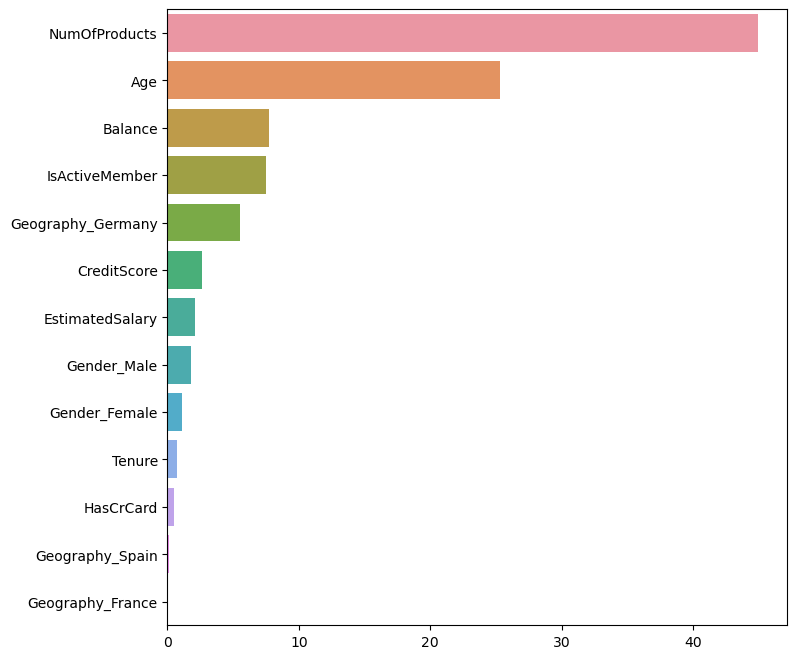

In [85]:
# 주요 특성 관찰
plt.figure(figsize=(8,8))
sns.barplot(x=top_cols, y=top_cols.index)
plt.show()

# 결과:
- xgb : 이상치 제거 전 후의 순위 동일
- cat : 이상치 제거 후 3,4위 순위인 잔액 > 활성멤버 여부 순위 변동(이상치 제거 전: 활성 멤버 여부 > 잔액 순) 
- 특성 중요도에서 두드러진 변화 없음